In [2]:
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [3]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

 ## 2.3 Load Image into TF Data Pipeline

images = tf.data.Dataset.list_files('data\\images\\*.jpg')

images.as_numpy_iterator().next()

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

 # 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipeline

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [9]:
img = cv2.imread(os.path.join('data','train', 'images','2508.jpg'))

In [10]:
with open(os.path.join('data', 'train', 'labels', '2508.json'), 'r') as f:
    label = json.load(f)

In [11]:
label['shapes'][0]['label']

'not crossing'

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [12]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [13]:
coords

[18.666666666666664, 572.7777777777777, 103.11111111111111, 790.5555555555555]

In [14]:
img.shape

(1080, 1920, 3)

In [15]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))

In [16]:
coords

[0.00972222222222222,
 0.5303497942386831,
 0.053703703703703705,
 0.7319958847736625]

In [17]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])

In [18]:
augmented['bboxes'][0][2:]

(0.053703703703703705, 0.4696502057613169)

In [19]:
list(augmented['bboxes'][0])

[0.00972222222222222,
 0.2680041152263375,
 0.053703703703703705,
 0.4696502057613169]

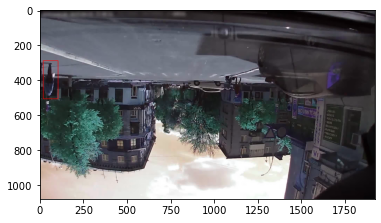

In [20]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1920,1080]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1920,1080]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(2):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                # print(len(augmented['bboxes']))
                # print(augmented['class_labels'][0])
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else:
                        # print('in')
                        annotation['bbox'] = list(augmented['bboxes'][0])
                        if augmented['class_labels'][0] == 'crossing':
                            # print('crossing')
                            annotation['class'] = 1
                        elif augmented['class_labels'][0] == 'might cross':
                            annotation['class'] = 2
                        elif augmented['class_labels'][0] == 'not crossing':
                            annotation['class'] = 3

                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
            
            # print(annotation)


            with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [21]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (500,500)))
train_images = train_images.map(lambda x: x/255)

In [22]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [23]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [24]:
train_images.as_numpy_iterator().next()

array([[[0.01568628, 0.05490196, 0.09411765],
        [0.01568628, 0.05490196, 0.09411765],
        [0.03137255, 0.07058824, 0.10980392],
        ...,
        [0.29803923, 0.34117648, 0.34901962],
        [0.29749063, 0.34062788, 0.34847102],
        [0.2784314 , 0.32156864, 0.32941177]],

       [[0.02541177, 0.06462745, 0.10384314],
        [0.02541177, 0.06462745, 0.10384314],
        [0.04109804, 0.08031373, 0.11952941],
        ...,
        [0.29803923, 0.34117648, 0.34901962],
        [0.29749063, 0.34062788, 0.34847102],
        [0.2784314 , 0.32156864, 0.32941177]],

       [[0.04274509, 0.08196078, 0.1172549 ],
        [0.04274509, 0.08196078, 0.1172549 ],
        [0.05843137, 0.09764706, 0.13294119],
        ...,
        [0.2901961 , 0.34509805, 0.34901962],
        [0.2896475 , 0.34454945, 0.34847102],
        [0.27058825, 0.3254902 , 0.32941177]],

       ...,

       [[0.9647059 , 1.        , 0.99607843],
        [0.9647059 , 1.        , 0.99607843],
        [0.9647059 , 1

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [25]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    # print(label['class'])
    # print(label['class'])
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [26]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [28]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [30]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3500, 1750, 748, 374, 750, 375)

### 7.2 Create Final Datasets (Images/Labels)

In [31]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [32]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [33]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [34]:
train.as_numpy_iterator().next()[0].shape

(8, 500, 500, 3)

### 7.3 View Images and Annotations

In [35]:
data_samples = train.as_numpy_iterator()

In [36]:
res = data_samples.next()

In [37]:
# res

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(500,500))
for idx in range(2): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    print(np.multiply(sample_coords[:2], [1920,1080]).astype(int))
#     cv2.rectangle(sample_image, 
#                   tuple(np.multiply(sample_coords[:2], [1920,1080]).astype(int)),
#                   tuple(np.multiply(sample_coords[2:], [1920,1080]).astype(int)), 
#                         (255,0,0), 2)

#     ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [79]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 5s 0us/step


In [80]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [81]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [82]:
facetracker = build_model()

In [83]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [84]:
X, y = train.as_numpy_iterator().next()

In [85]:
X.shape

(8, 120, 120, 3)

In [86]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 17s 17s/step


In [87]:
classes, coords

(array([[0.55136245],
        [0.6347786 ],
        [0.5534485 ],
        [0.56574744],
        [0.5551873 ],
        [0.53027695],
        [0.54876614],
        [0.58250487]], dtype=float32),
 array([[0.35698834, 0.668704  , 0.35447955, 0.41109896],
        [0.3673756 , 0.67861277, 0.3453343 , 0.3141164 ],
        [0.33764535, 0.5693774 , 0.4271268 , 0.32106856],
        [0.38460702, 0.59908044, 0.35710824, 0.38815692],
        [0.40372977, 0.5753246 , 0.34630486, 0.41485533],
        [0.3497103 , 0.6443349 , 0.32930353, 0.37878478],
        [0.40045226, 0.59222764, 0.38682982, 0.3777911 ],
        [0.40239045, 0.64911884, 0.34654027, 0.35023943]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [88]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [89]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [90]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [91]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [92]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.4314559>

In [93]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.56057274>

In [94]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.4314559>